## Proyecto Final: Descubriendo CDMX
_**Realizó:**_ David Pérez Mijangos

_Materia:_ Matemáticas Discretas para Ciencia de Datos

_Profesor:_ Leonardo Ignacio Martínez Sandoval

_Ayudante:_ Rodolfo Figueroa Soriano

### Importando bibliotecas y datos

In [15]:
# Se importan las librerías necesarias
from libpysal.weights import Queen
import numpy as np
import geopandas
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import requests
import json
from geopy.geocoders import Nominatim
from geopy import distance

# Se establece el path de trabajo
path = 'RecreacionCDMX/'

In [16]:
# Se leen los datos de los espacios culturales de la CDMX por categoría
clases = ["Casas de Artesanias", "Catedrales", "Centros Culturales", "Cines", 
          "Fonotecas", "Fototecas", "Galerias", "Museos", "Bibliotecas", 
          "Teatros", "Zonas Arqueologicas"]
clases_mapping = {"Casas de Artesanias": 0, "Catedrales": 1, "Centros Culturales": 2,
                  "Cines": 3, "Fonotecas": 4, "Fototecas": 5, "Galerias": 6, 
                  "Museos": 7, "Bibliotecas": 8, "Teatros": 9, "Zonas Arqueologicas": 10}
espacios_culturales = [pd.read_csv(path + clases[i] + '.csv', encoding='latin-1') for i in range(11)]

# Se guarda la longitud de conjunto de datos para cada espacio cultural
l_espc = [len(espacios_culturales[i]) for i in range(11)]

### Creación de la gráfica de la gráfica de adyacencias para los códigos postales

C:\Users\david\AppData\Local\Temp\ipykernel_11212\672776338.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((codigos_postales.centroid.x, codigos_postales.centroid.y))


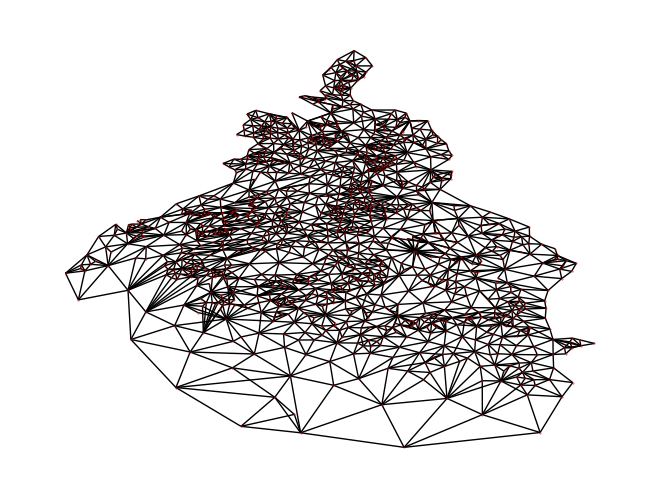

In [17]:
# leer datos de los codigos postales de geojson. GeoJSON es un formato de archivo
# para codificar datos geográficos basados en JSON. Es útil para
# presentar datos geográficos en la web
codigos_postales = geopandas.read_file(path + 'Correos Postales.geojson')
codigos_postales.d_cp = codigos_postales.d_cp.astype(int, copy=False)

# Se ordena el conjunto de datos de los codigos postales
codigos_postales.sort_values(by=['d_cp'], inplace=True)

# Se eguarda una lista con los codigos postales ordenados
cp_sorted = codigos_postales.d_cp.values.tolist()

# extraer los centroides para conectar las regiones, lo cual es
# el promedio de las coordenadas que definen el límite del polígono
# Esto solo se utiliza para graficar el gráfico de adyacencia.
centroids = np.column_stack((codigos_postales.centroid.x, codigos_postales.centroid.y))

# Construir el gráfico de adyacencia. En aplicaciones geográficas,
# el gráfico de adyacencia considera dos polígonos como conectados si
# comparten al menos un punto en su límite. Se utiliza libpysal para esto
queen = Queen.from_dataframe(codigos_postales, use_index=True)

# Luego, podemos convertir el gráfico en un objeto networkx usando el
# Método .to_networkx().
graph = queen.to_networkx()

# Para trazar con networkx, necesitamos fusionar los nodos nuevamente para
# sus posiciones para trazar en networkx
positions = dict(zip(graph.nodes, centroids))
nx.draw(graph, positions, node_size=0.1, node_color="r")
plt.show()

### Implementación de búsqueda binaria y corrector de CPs

In [18]:
# Se define la fución para hacer busqueda binaria, esto se utilizara más adelante
# para encontrar el código postal más cercano a un punto dado
def encontrar_posicion(nuevo_numero, lista):
    inicio = 0
    fin = len(lista) - 1

    while inicio <= fin:
        medio = (inicio + fin) // 2

        if lista[medio] == nuevo_numero:
            # El número ya está en la lista, devuelve la posición actual
            return medio
        elif lista[medio] < nuevo_numero:
            # El nuevo número está en la mitad derecha
            inicio = medio + 1
        else:
            # El nuevo número está en la mitad izquierda
            fin = medio - 1

    # Cuando el bucle termina, 'inicio' será la posición donde se debe insertar el nuevo número
    return inicio

In [19]:
# Se define la función para encontrar el código postal más cercano a un punto dado
# usando busqueda binaria sobre la lista de códigos postales ordenados
def encontrar_cp(zip, lista=cp_sorted):
  k = encontrar_posicion(zip, lista)
  # Se exploran los casos en los que el código postal más cercano es el primero,
  # el último, el penúltimo o cualquier otro
  if k == 0:
    cp = lista[k]
  elif k == len(lista):
    cp = lista[k-1]
  elif k == len(lista)-1:
    d = [(lista[k-1], abs(zip-lista[k-1])),
          (lista[k], abs(zip-lista[k]))]
    cp = min(d, key=lambda norm: norm[1])[0]
  else:
    d = [(lista[k-1], abs(zip-lista[k-1])),
        (lista[k], abs(zip-lista[k])),
        (lista[k+1], abs(zip-lista[k+1]))]
    cp = min(d, key=lambda norm: norm[1])[0]
  return cp

### Creación de la gráfica de códigos postales con los espacios culturales por categría

In [20]:
# Se genera un diccionario con los datos de los espacios culturales,
# agrupados por código postal y posteriormente por categoría.

# Se crea un diccionario con los códigos postales como llaves y
# dataframes vacíos como valores.
nodos = {}
for i in cp_sorted:
  nodos[i] = {j:pd.DataFrame(columns=espacios_culturales[0].columns) for j in range(11)}

# Se llenan los dataframes de cada código postal con los datos de los espacios
# culturales correspondientes. Esto se hace recorriendo en su totalidad cada categoría.
for i in range(11):
  categoria = espacios_culturales[i]
  for j in range(len(categoria)):
    # El código postal dado a un espacio cultural puede estar desactualizado
    # o no aparecer en la lista de códigos postales. En este caso, se busca el
    # código postal más cercano al punto dado y este es el que se le asigna.
    # Esto se hace con la función encontrar_cp definida anteriormente, usando
    # busqueda binaria.
    cp = encontrar_cp(categoria.cp[j])
    nodos[cp][i].loc[len(nodos[cp][i])] = categoria.loc[j]

# Finalmente, se crea una lista de tuplas con los códigos postales y su correspondiente
# conjunto de datos con los espacios culturales agrupados por categoría. Esto se hace
# ya que es el formato que requiere la función de networkx para crear el grafo.
vertices = [(cp, nodos[cp]) for cp in cp_sorted]

In [21]:
# Se crea el grafo con networkx
graph_cultura_cp = nx.Graph()

# Se agregan los nodos usando la lista de tuplas creada anteriormente
graph_cultura_cp.add_nodes_from(vertices)

# Se agregan las aristas al grafo, estas aristas son las misma que las
# del grafo de adyacencia de los códigos postales definido anteriormente.
for i in list(graph.nodes):
  for j in list(graph.adj[i]):
    graph_cultura_cp.add_edge(codigos_postales.iloc[i,0],codigos_postales.iloc[j,0])

In [22]:
# Ejemplo de como acceder a los datos de un espacio cultural por código postal
# y categoría.
graph_cultura_cp.nodes[4360][8]

categoria                                             nombre   nom_mun  \
0  Bibliotecas  Biblioteca Conjunta de Ciencias de la Tierra  ...  Coyoacán   
1  Bibliotecas  Biblioteca Antonio Caso                       ...  Coyoacán   
2  Bibliotecas                                     Nezahualcóyotl  Coyoacán   

                                  calle_numero  \
0  Circuito de la investigación Científica s/n   
1                        Circuito Escolar 3000   
2    Pehuame s/n, entre Tecacalco y Quauhnicol   

                                             colonia    cp       lon  \
0      Cd. Universitaria                         ...  4360 -99.17707   
1         Cd. Universitaria                           4360 -99.18597   
2                                Adolfo Ruiz Cotines  4360  -99.1462   

        lat                                           link_sic  
0  19.32619  http://sic.gob.mx/ficha.php?table=otra_bib&tab...  
1   19.3346  http://sic.gob.mx/ficha.php?table=otra_bib&tab...  
2  19.32119  http://sic.gob.mx/ficha.php?table=rnbp&table_i...

### Uso de API y librería para obtener la ubicación del usuario

Se extraen las coordenadas y el código postal de la ubicación del usuario a través de su IP

In [23]:
# URL de la API
api_url = "http://ip-api.com/json/"

# Definimos los parametros de respuesta que queremos obtener
parametros = 'status,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,query'
data = {"fields":parametros}

def ip_scraping(ip=""):
  # Nos conectamos con la API
  res = requests.get(api_url+ip, data=data)
  # Obtenemos y procesamos la respuesta JSON
  api_json_res = json.loads(res.content)
  #Regresamos las coordenadas, código postal y ciudad
  return api_json_res['lat'], api_json_res['lon'], int(api_json_res['zip']), api_json_res['city']

ip_scraping()

(19.3692, -99.1616, 3310, 'Santa Cruz Atoyac')

Se extrae el código postal del usuario a partir de sus coordenadas

In [24]:
def coord_scrapping(lat, lon):
  # Llamamos la herramienta nominatim
  geoLoc = Nominatim(user_agent="GetLoc")

  # Pasamos las coordenadas
  locname = geoLoc.reverse(str(lat) + "," + str(lon)).address

  # Regresamos el código postal y la ciudad
  locname = [i.strip() for i in locname.split(",")]
  return int(locname[-2]), locname[-3]

coord_scrapping(19.4326, -99.1332)

(6000, 'Ciudad de México')

### Implentación del buscador de lugares culturales cercanos

In [25]:
# Se define la función para obtener las recomendaciones de espacios culturales
# dado un punto (latitud, longitud) o la dirección IP del dispositivo.
def recomendaciones(lat=None, lon=None, n=3):
  '''
  Esta función regresa un dataframe con los espacios culturales más cercanos
  a las coordenadas dadas o a la ubicación del dispositivo (si no se proporcionan
  las coordenadas). Los espacios culturales se agrupan por categoría y se ordenan
  por proximidad.
  
  Parámetros:
    lat: latitud del punto de referencia o de interés (opcional), None por defecto.
    lon: longitud del punto de referencia o de interés (opcional), None por defecto.
    n: número de lugares recomendados por categoría (opcional), 3 por defecto.
  
  Regresa:
    lugares: dataframe con los espacios culturales más cercanos, agrupados por categoría 
              y ordenados por cercanía al punto dado.
  
  Ejemplo:
    recomendaciones(lat=19.4326, lon=-99.1332, n=3)
    
    recomendaciones(n=5)
    
  Nota: Si no se proporcionan las coordenadas, se obtienen de la IP pública del dispositivo,
        esto puede no ser preciso ya que la IP puede no corresponder a la ubicación e incluso
        puede no ser de la Ciudad de México. Por lo que se recomienda proporcionar las coordenadas.
  '''
  
# Se definen las variables globales que se utilizarán
  global graph_cultura_cp, cp_sorted, espacios_culturales, l_espc
  
# Se inicializan las variables locales
  g = graph_cultura_cp
  
  # Se genera un diccionario con los nodos visitados para hacer una 
  # búsqueda por amplitud.
  visitados = {i:False for i in graph_cultura_cp.nodes}
  
  # Se define el conjunto de columnas que se utilizarán para el dataframe que verá el usuario
  columnas = ['Categoría', 'Nombre', 'Alcaldía', 'Dirección', 'Colonia', 'C.P.', 'Ficha Técnica SIC','Distancia (km)']
  
  # Se define el conjunto de columnas que se utilizarán de los dataframes originales
  col_index = [0, 1, 2, 3, 4, 5, 8]
  
  # Se inicializa un diccionario donde se guardarán los lugares recomendados, siendo estos
  # los más cercanos al punto dado. Los valores son dataframes vacíos.
  lugares = {i:pd.DataFrame(columns=columnas) for i in range(11)}
  
  # Se inicializa una lista que indica si ya se encontró el número de lugares
  l = [False]*11

  # Si se proporcionan las coordenadas, se obtiene el código postal y la ciudad
  if lat and lon:
    cp, ciudad = coord_scrapping(lat, lon)
  
  # Si no se proporcionan las coordenadas, se obtienen de la IP del dispositivo,
  # esto puede no ser preciso ya que la IP puede no corresponder a la ubicación e incluso
  # puede no ser de la Ciudad de México. Por lo que se recomienda proporcionar las coordenadas
  else:
    lat, lon, cp, ciudad = ip_scraping()
    
  # Se verifica que el código postal sea de la Ciudad de México, de lo contrario
  # se regresa un mensaje de error.
  if ciudad != 'Ciudad de México' and ciudad != 'Mexico City':
    return "No estás en la Ciudad de México"
  
  # Se incializa una cola para hacer la búsqueda por amplitud, se agrega el vértice inicial
  q = [cp]
  
  # Se marca el vértice inicial como visitado
  visitados[cp] = True
  
  # Se realiza la búsqueda por amplitud hasta encontrar el número de lugares requeridos,
  # o hasta que se hayan recorrido todos los nodos.
  while q and sum(l) <= 11:
    u = q.pop(0)
    
    # Para el vértice actual, se recorren todas las categorías
    for i in range(11):
      
      # Accedemos a la categoría i del vértice actual
      categoria = g.nodes[u][i]
      
      # Si aún no se han encontrado los lugares requeridos, la categoría local (del vértice) no está vacía
      # y aún quedan datos que se puedan agregar, se actualiza el diccionario de recomendaciones.
      if not l[i] and categoria.empty == False and len(lugares[i]) < l_espc[i]:
        
        # Se calcula la distancia entre el punto dado y todos los lugares de la categoría actual
        d = [[j, distance.distance((lat, lon), (categoria.lat[j], categoria.lon[j])).km] for j in range(len(categoria))]
        
        # Se ordenan los lugares por cercanía al punto dado
        d = np.array(sorted(d, key=lambda norm: norm[1]))
        
        # Se agregan los datos de los lugares más cercanos al diccionario de recomendaciones
        # sin exceder el número de lugares requeridos.
        if len(lugares[i]) + len(d) <= n:
          tmp = pd.DataFrame(categoria.iloc[d[:,0], col_index].values, columns=columnas[:7])
          tmp['Distancia (km)'] = d[:,1]
          if lugares[i].empty == False:
            lugares[i] = pd.concat([lugares[i], tmp],ignore_index=True, axis=0)
          else:
            lugares[i] = tmp
  
        if n < len(lugares[i]) + len(d):
          tmp = pd.DataFrame(categoria.iloc[d[:n-len(lugares[i]),0], col_index].values, columns=columnas[:7])
          tmp['Distancia (km)'] = d[:n-len(lugares[i]),1]
          if lugares[i].empty == False:
            lugares[i] = pd.concat([lugares[i], tmp],ignore_index=True, axis=0)
          else:
            lugares[i] = tmp
            
        # Se actualiza la lista de lugares encontrados
        l[i] = (len(lugares[i]) >= n) or (len(lugares[i]) >= l_espc[i])
        
    # Se agregan los vecinos del vértice actual a la cola, si no han sido visitados para
    # continuar la búsqueda por amplitud.
    for w in g.adj[u]:
      if not visitados[w]:
        visitados[w] = True
        q.append(w)
        
  # Para cada categoría de lugares encontrados, estos se ordenan por cercanía al punto dado.
  for i in range(11):
    lugares[i].sort_values(by=['Distancia (km)'], inplace=True)
    
  # Finalmente se juntan los dataframes de todas las categorías en uno solo para mostrarlo al usuario
  lugares = pd.concat(lugares.values(), ignore_index=True, axis=0)
  return lugares

### Ejemplo de uso

In [27]:
recomendaciones(19.337786, -99.177216, n=4)

Categoría                                             Nombre  \
0   Casas de Artesanías  Casa de Artesanías Uriarte Talavera, Sucursal ...   
1   Casas de Artesanías                                        Casa Mejicú   
2   Casas de Artesanías  Tienda de Artesanías del Fonart, Sucursal Patr...   
3   Casas de Artesanías  Tienda de Artesanías IAIP, Sucursal Distrito F...   
4            Catedrales                       Nuestra Señora de Balvanera    
5            Catedrales                       Nuestra Señora de Balvanera    
6            Catedrales                                        Porta Coeli   
7            Catedrales  Catedral Metropolitana La Asunción de la Virge...   
8    Centros Culturales                                Foro Arnaldo Orfila   
9    Centros Culturales                Casa de Cultura Jesús Reyes Heroles   
10   Centros Culturales                Casa de Cultura Jesús Reyes Heroles   
11   Centros Culturales                              Centro de Artes Vivas   
12                Cines                           Cinépolis Oasis Coyoacán   
13                Cines                       Cinépolis VIP Oasis Coyoacán   
14                Cines                   Cinemex Patio Revolución Platino   
15                Cines                                   Cinemanía Loreto   
16            Fonotecas                                  Fonoteca Nacional   
17            Fonotecas  Dirección General de Culturas Populares e Indí...   
18            Fonotecas  Dirección General de Culturas Populares e Indí...   
19            Fonotecas              Fonoteca de la Biblioteca Cuicamatini   
20            Fototecas  Diapositeca Digital de la Facultad de Arquitec...   
21            Fototecas  Fototeca del Instituto Nacional de Estudios Hi...   
22            Fototecas  Instituto de Investigaciones Estéticas de la UNAM   
23            Fototecas  Fototeca del Centro de Información y Documenta...   
24             Galerías               La Era del Arte, Suc. Oasis Coyoacán   
25             Galerías                  Galería Expresarte Mauricio Achar   
26             Galerías                               Sala René Villanueva   
27             Galerías                       Galería Veracruzana del Arte   
28               Museos                    Casa Fuerte del Indio Fernández   
29               Museos   Museo Nacional de la Acuarela Alfredo Guati Rojo   
30               Museos                                 Museo de El Carmen   
31               Museos  Centro Cultural Isidro Fabela-Museo Casa del R...   
32          Bibliotecas  Biblioteca Antonio Caso                       ...   
33          Bibliotecas  Biblioteca Conjunta de Ciencias de la Tierra  ...   
34          Bibliotecas  Biblioteca Salvador Novo                      ...   
35          Bibliotecas                                     Nezahualcóyotl   
36              Teatros                             Teatro Carpa Geodésica   
37              Teatros                                 Teatro López Tarso   
38              Teatros                               Teatro Rafael Solana   
39              Teatros                                  Teatro Lola Cueto   
40  Zonas Arqueológicas                                          Cuicuilco   
41  Zonas Arqueológicas                                            Mixcoac   
42  Zonas Arqueológicas                               Cerro de la Estrella   
43  Zonas Arqueológicas                                       Templo Mayor   

          Alcaldía                                          Dirección  \
0   Álvaro Obregón                                        Amargura 17   
1         Coyoacán                              Calz de Tlalpan 2191    
2    Benito Juárez                                Av. Patriotismo 691   
3       Cuauhtémoc                                Av. Chapultepec 494   
4       Cuauhtémoc                  Correo Mayor esq. Rep. de Uruguay   
5       Cuauhtémoc                  Correo Mayor esq. Rep. de Uru